# Result of time-domain inference on fiducial BBH injection with IMRPhenomXPHM

In [23]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify, h5py
import bilby
from scipy.stats import norm, gaussian_kde
import shutil
from tqdm import tqdm
import lal
import json

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
cmap1 = sns.color_palette('colorblind')
cmap2 = sns.color_palette('dark')

import sys, os
sys.path.append('/home/simona.miller/time-domain-gw-inference')
from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result
Load in the time-domain inference result using the functionality of `group_postprocess`.

In [2]:
def load_TD_results(run): 

    # Load in the result
    result = group_postprocess.load_run_settings_from_directory(
        'output/'+run,
        filename_dict={'full':'full_0.0seconds'}
    )
    
    # Likelihood manager 
    lm = result['runs']['full']['likelihood_manager']  
    
    # Extract the posterior
    posterior = result['dfs']['full']

    # To match bilby convention
    posterior['polarization'] = posterior['polarization'] % np.pi

    # Needed for prior reweighting later
    posterior['chirp_mass'] = utils.get_chirpmass(posterior['mass1'], posterior['mass2'])

    return posterior, result, lm 

run = '250722_output'
TD_posterior, TD_result, lm = load_TD_results(run)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


In [24]:
# Get reference parameters
with open(os.path.join(TD_result['dir'], TD_result['runs']['full']['args'].reference_parameters)) as f:
    reference_parameters = json.load(f)

Load in the `bilby` result for comparison.

In [4]:
# # Load in the result
# FD_result = h5ify.load(
#     os.path.join('output/'+run, TD_result['runs']['full']['args'].pe_posterior_h5_file)
# )
# # Extract the posterior
# FD_posterior = FD_result['C01:IMRPhenomXPHM']['posterior_samples']

### Prior reweighting
The two runs differ in the priors for masses, luminosity distance, and time. First, make a bilby prior object with some useful priors:

In [5]:
# # Extract prior
# from bilby.core.prior import PriorDict, PowerLaw
# from bilby.gw.prior import UniformInComponentsChirpMass

# _bilby_prior = FD_result['C01:IMRPhenomXPHM']['priors']['analytic']

# bilby_prior = bilby.core.prior.PriorDict()
# bilby_prior['luminosity_distance'] = eval(_bilby_prior['luminosity_distance'][0].decode(encoding='utf-8'))
# bilby_prior['chirp_mass'] = eval(_bilby_prior['chirp_mass'][0].decode(encoding='utf-8'))

# print(bilby_prior)

In [6]:
# # Jacobian between uniform in (M,q) <--> uniform in (m1,m2)
# def get_jacobian(m1, m2):
#     return m1**2/(m1+m2)

# # Calculate bilby prior weights on the TD samples for parameters of interest (masses, distance)
# p_bilby_masses = get_jacobian(TD_posterior['mass1'], TD_posterior['mass2'])
# p_bilby_DL =  bilby_prior['luminosity_distance'].prob(TD_posterior['luminosity_distance'])
# p_bilby = p_bilby_masses * p_bilby_DL

# # Calculate TD prior on the TD samples for parameters of interest (geocenter time) 
# p_TD = norm.pdf(TD_posterior['geocenter_time'], loc=lm.reference_time, scale=lm.sigma_time)

# # Reweight
# weights = p_bilby / p_TD

# # Hard cut on chirp mass
# td_mask = (TD_posterior['chirp_mass'] > bilby_prior['chirp_mass'].minimum) & (TD_posterior['chirp_mass'] < bilby_prior['chirp_mass'].maximum) 
# weights[~td_mask] = 0

# td_mask_2 = TD_posterior['mass_ratio'] < 0.4
# weights[td_mask_2] = 0

In [7]:
# # Calculate the effective number of samples
# from scipy.special import logsumexp
# logwts = np.log(weights)
# logneff = logsumexp(logwts) * 2 - logsumexp(logwts * 2)
# neff = np.exp(logneff)

# print('total samples:', len(weights))
# print('effective samples:', neff)

## Plot comparison

The two codes use different naming keys for the parameters, so we must set up a dictionary to translate between them:

In [8]:
# keys = bilby keys; values = TD keys
key_transform = {
    'mass_ratio':'mass_ratio', 
    'total_mass':'total_mass',
    'mass_1':'mass1',
    'mass_2':'mass2',
    'luminosity_distance':'luminosity_distance',
    'a_1':'spin1_magnitude',
    'a_2':'spin2_magnitude',
    'tilt_1':'tilt1',
    'tilt_2':'tilt2',
    'phi_12':'phi12',
    'phi_jl':'phi_jl',
    'theta_jn':'theta_jn',
    'ra':'right_ascension', 
    'dec':'declination',
    'psi':'polarization',
    'phase':'phase',
    'geocent_time':'geocenter_time'
}

In [9]:
# # make empty dict
# JSD_dict = {}

# # we care about masses and spins; there are slightly different naming conventions 
# # between the two codes
# param_names = ['total_mass', 'mass_ratio', 'mass1', 'mass2', 
#                'chi_effective', 'chi_precessing', 'spin1_magnitude', 'spin2_magnitude'] 
# param_names_bilby = ['total_mass', 'mass_ratio', 'mass_1', 'mass_2', 
#                      'chi_eff', 'chi_p', 'a_1', 'a_2'] 

# # cycle through parameters
# for pb,p in key_transform.items():

#     # calculate JSD
#     JSD = utils.calculate_js(
#         samplesA=FD_posterior[pb], 
#         samplesB=TD_posterior[p],
#         ntests=100, 
#         nsamples=int(neff/2)
#     )

#     JSD_rw = utils.calculate_js(
#         samplesA=FD_posterior[pb], 
#         samplesB=TD_posterior[p],
#         weightsB=weights/np.sum(weights),
#         ntests=100, 
#         nsamples=int(neff/2)
#     )

#     # print its information
#     JSD_str = f"JSD: {JSD.median * 1e3:0.1f}+{JSD.plus * 1e3:0.1f}-{JSD.minus * 1e3:0.1f} mb"
#     print(pb, JSD_str)

#     # add to dict
#     JSD_dict[pb] = {'td prior':JSD.median, 'fd prior':JSD_rw.median}

Generate comparison plot for the two posteriors

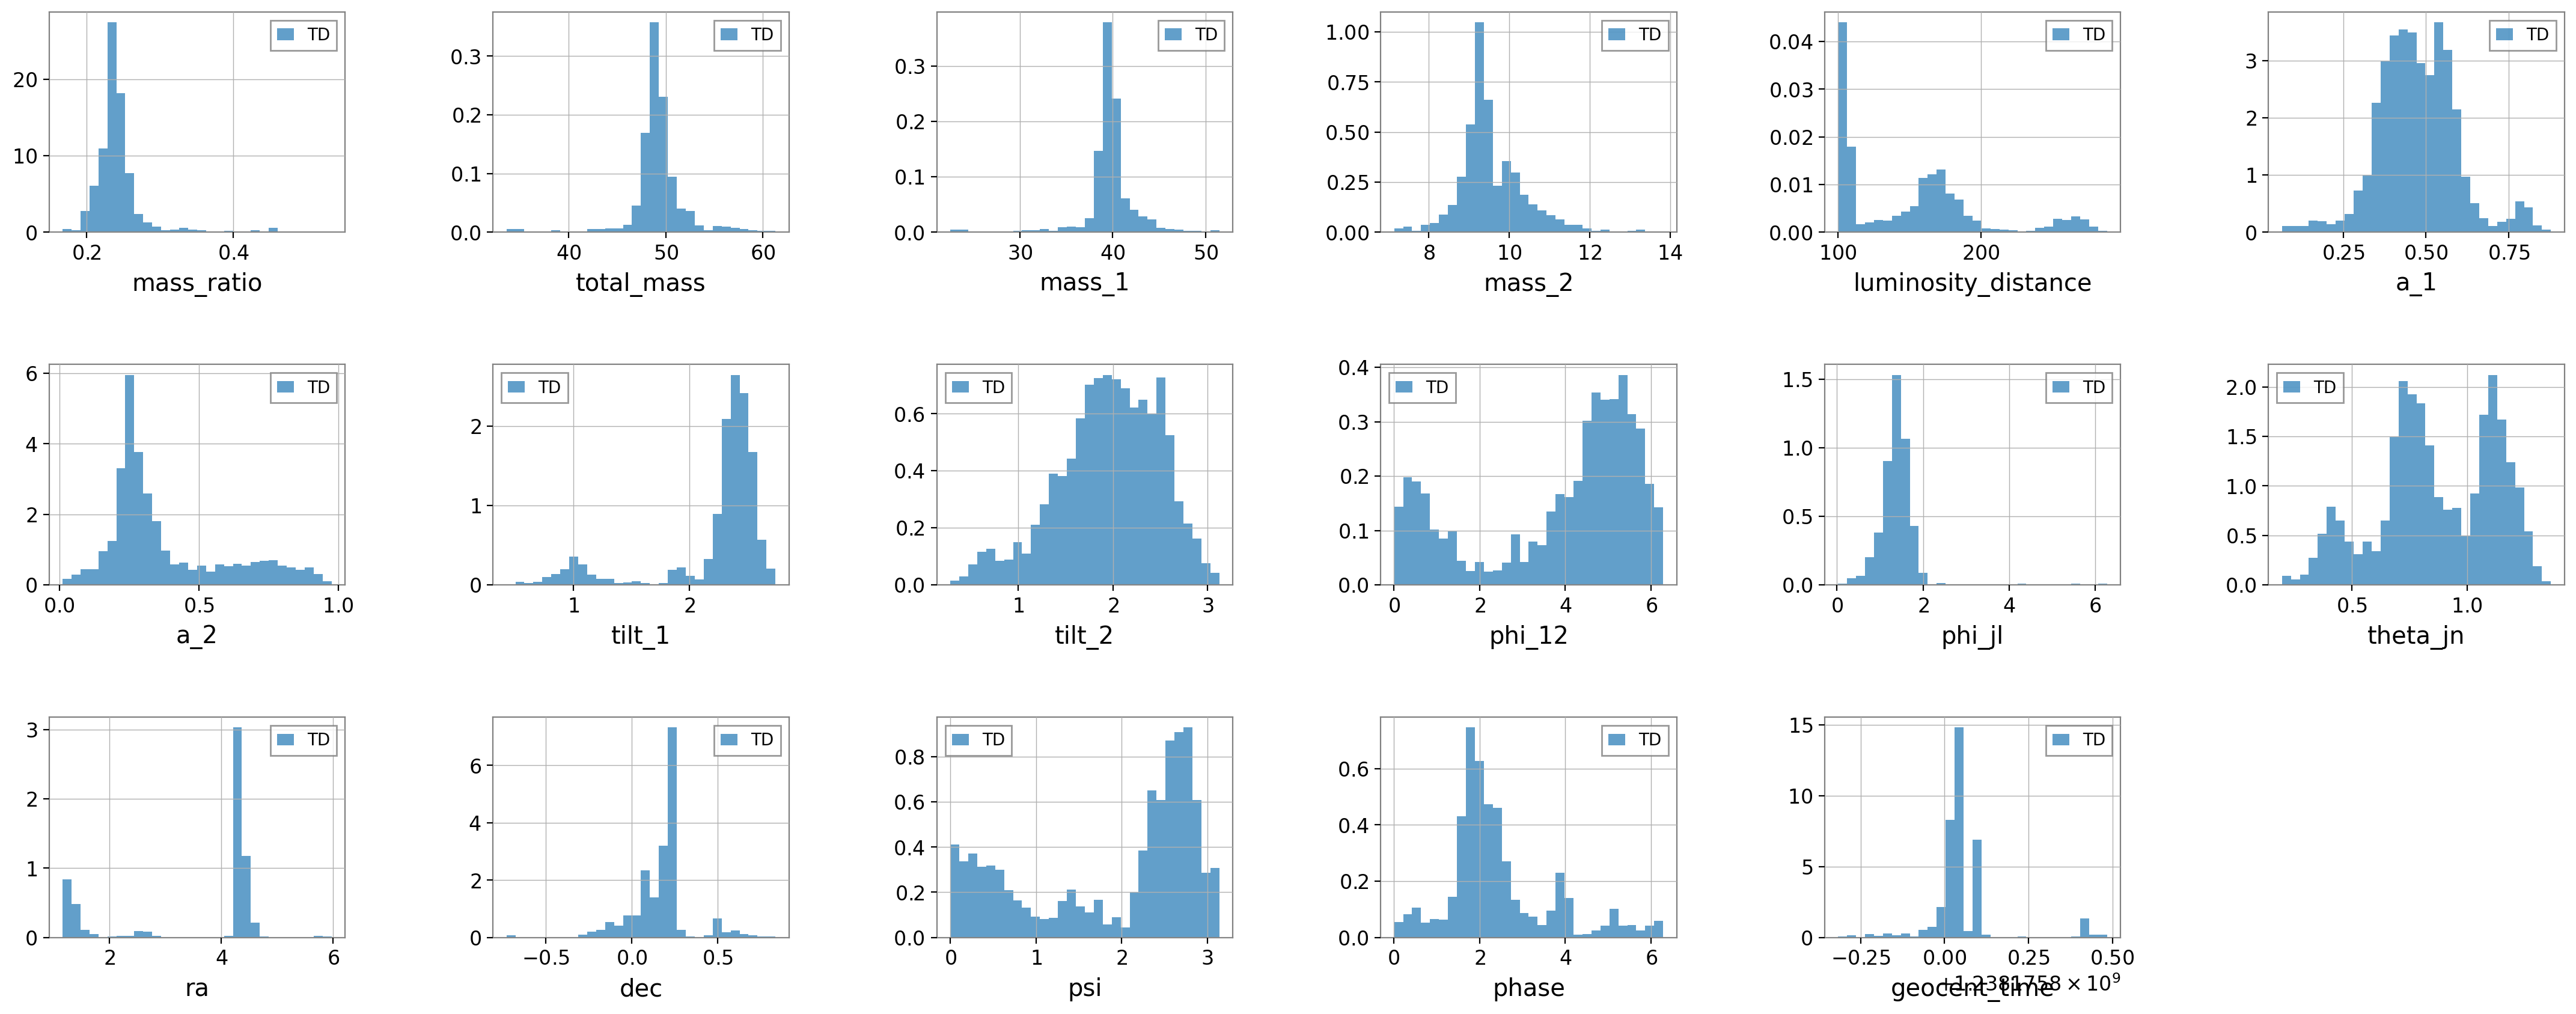

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    #ax.hist(FD_posterior[k], **hist_kws, color='gray',label='bilby')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='TD')
    #ax.hist(TD_posterior[key_transform[k]], **hist_kws, weights=weights, histtype='step', color='navy', lw=2, label='TD, RW')
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

    ax.axvline()

    # JS = round(JSD_dict[k]['td prior']*1e3, 1)
    # JS_rw = round(JSD_dict[k]['fd prior']*1e3, 1)
    # ax.set_title('JSD '+str(JS)+' mb\n JSD, RW: '+str(JS_rw)+' mb', fontsize=12)
    
plt.subplots_adjust(hspace=0.6, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

## Some checks: 

First, check for convergence by plotting the run from which `250722` was launched:

In [11]:
# run2 = '250721_output_longer_seg'
# TD_posterior2 = load_TD_results(run2)[0]

In [12]:
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

# for k, ax in zip(key_transform.keys(), axes.flatten()): 

#     hist_kws = dict(density=True, bins=30)
#     ax.hist(TD_posterior2[key_transform[k]], **hist_kws, color='C1', alpha=0.7, label='run 1')
#     ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='run 2')
        
#     ax.set_xlabel(k)
#     ax.legend(fontsize=10)

# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# axes[-1][-1].set_visible(False)
# plt.show()

And plot the MCMC chains themselves:

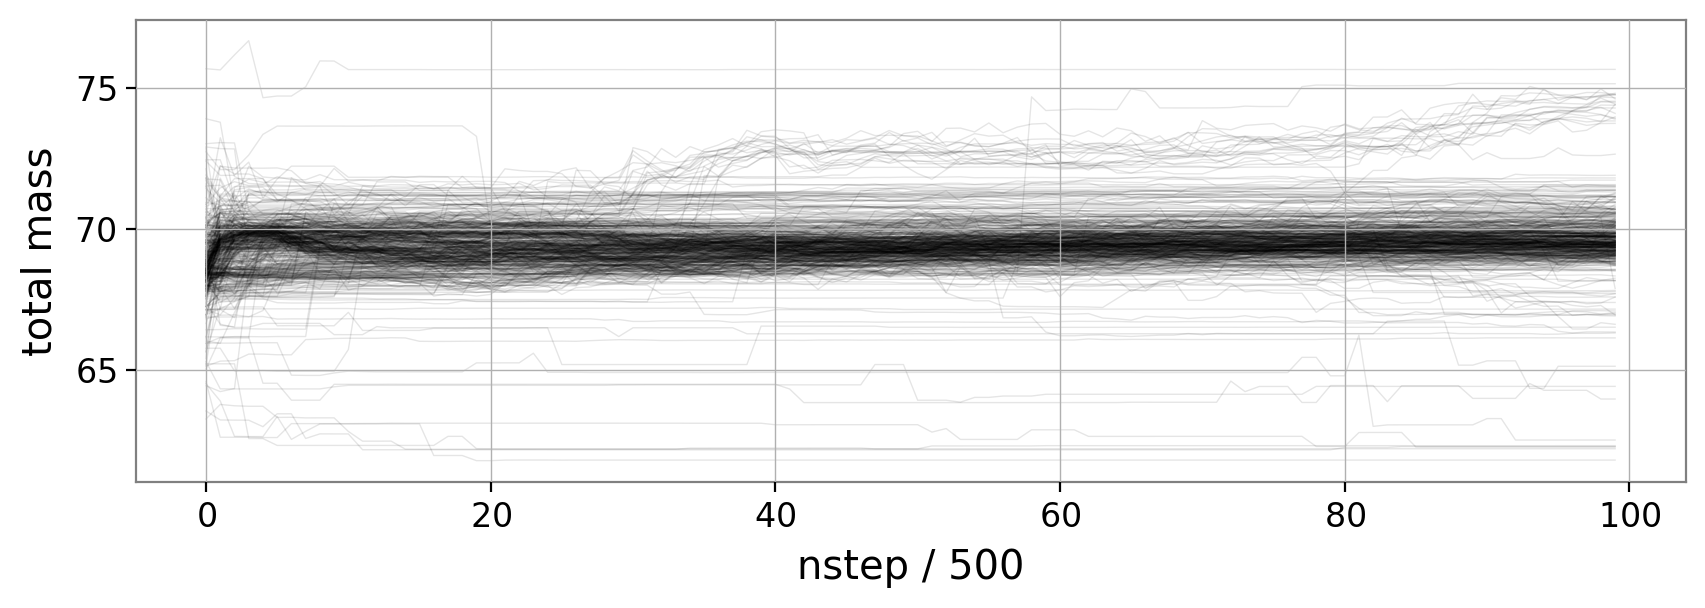

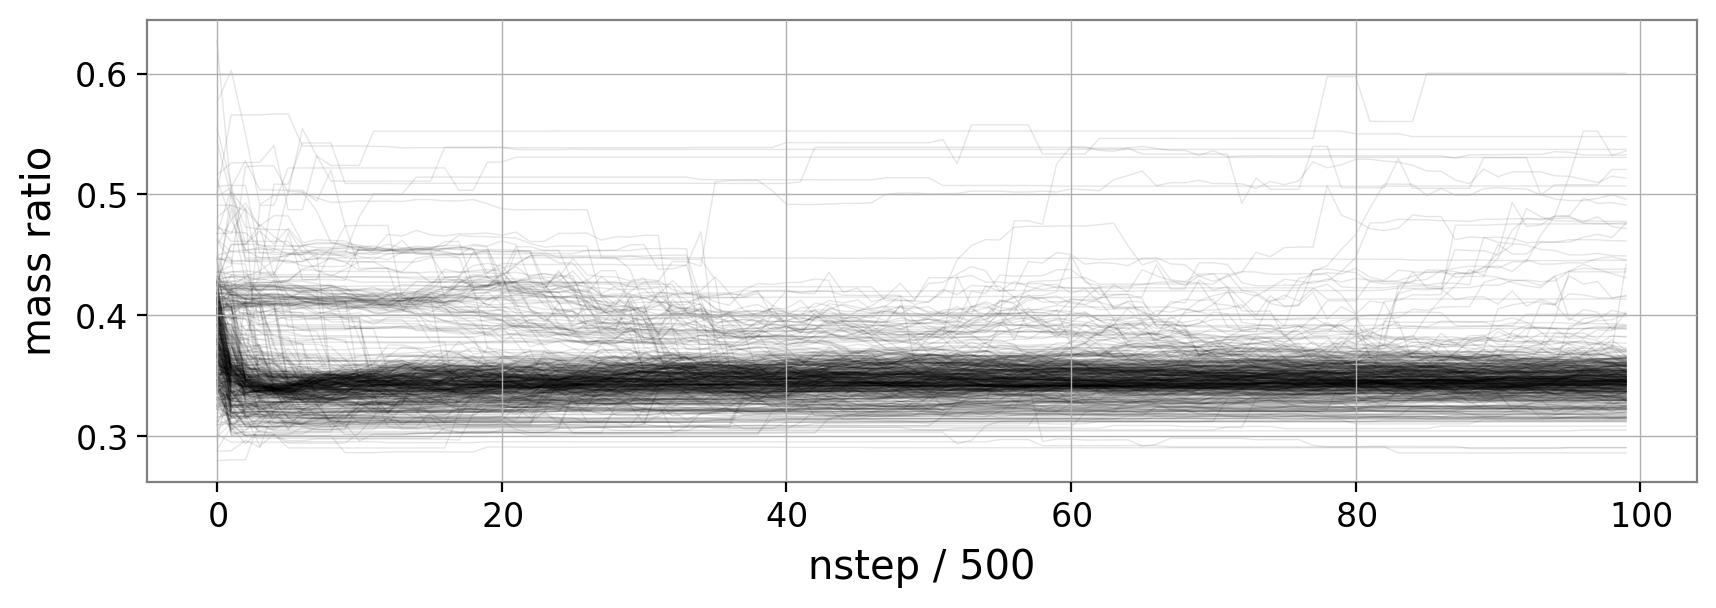

In [14]:
import emcee
f = f'output/{run}/full_0.0seconds/full_0.0seconds.h5'
backend = emcee.backends.HDFBackend(f, read_only=True) 

thin = 500
chain = backend.get_chain(thin=thin)

# plot total mass chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,0].T:
    ch_phys = utils.inv_logit(ch, 60, 80)
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('total mass')
plt.xlabel(f'nstep / {thin}');

# plot mass ratio chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,1].T:
    ch_phys = utils.inv_logit(ch, 0.25, 1)
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('mass ratio')
plt.xlabel(f'nstep / {thin}');

### Plot waveforms

In [28]:
# Load
wfs = waveform_h5s.load_waveform_h5py(f'output/{run}/waveforms/full_waveforms.h5')
# Whiten 
wfs_whitened = utils.whiten_wfs(wfs['samples'], lm)

In [29]:
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(reference_parameters, TD_result['runs']['full']['args'])
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)
# Whiten injection
injection_dict_whitened = {ifo : utils.whitenData(
    injection_dict[ifo], 
    lm.time_dict[ifo],
    lm.conditioned_psd_dict[ifo][:, 1], 
    lm.conditioned_psd_dict[ifo][:, 0]
) for ifo in lm.ifos}

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


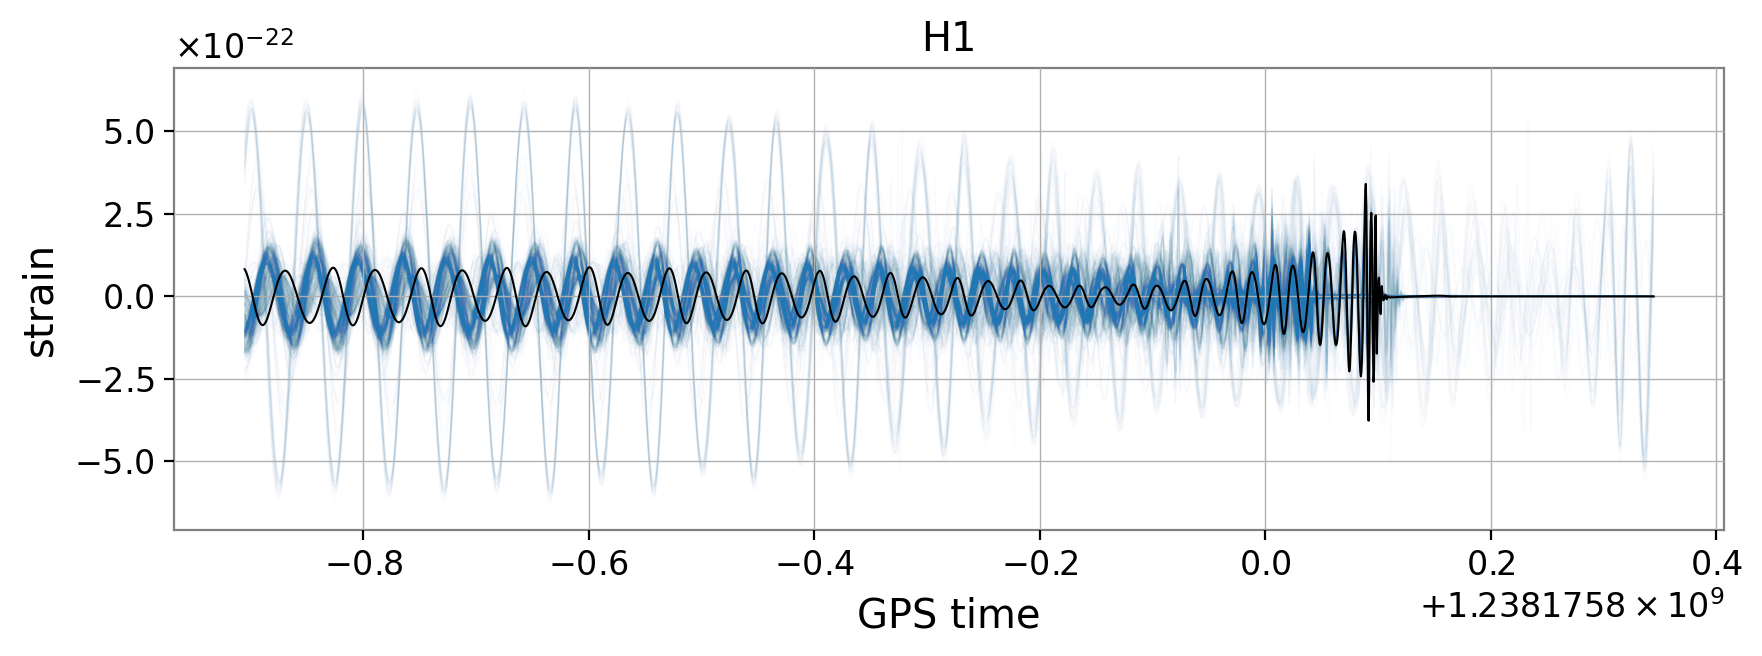

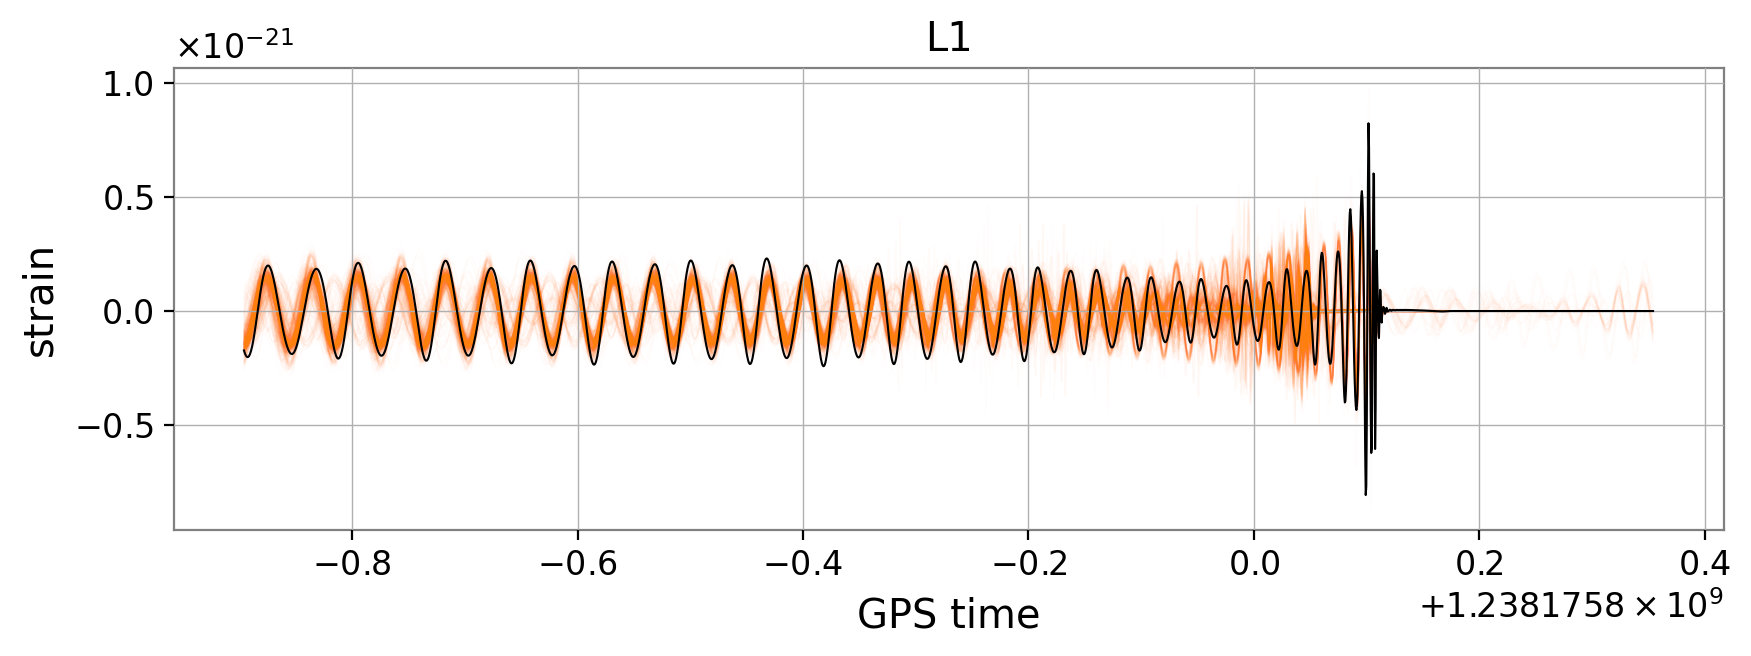

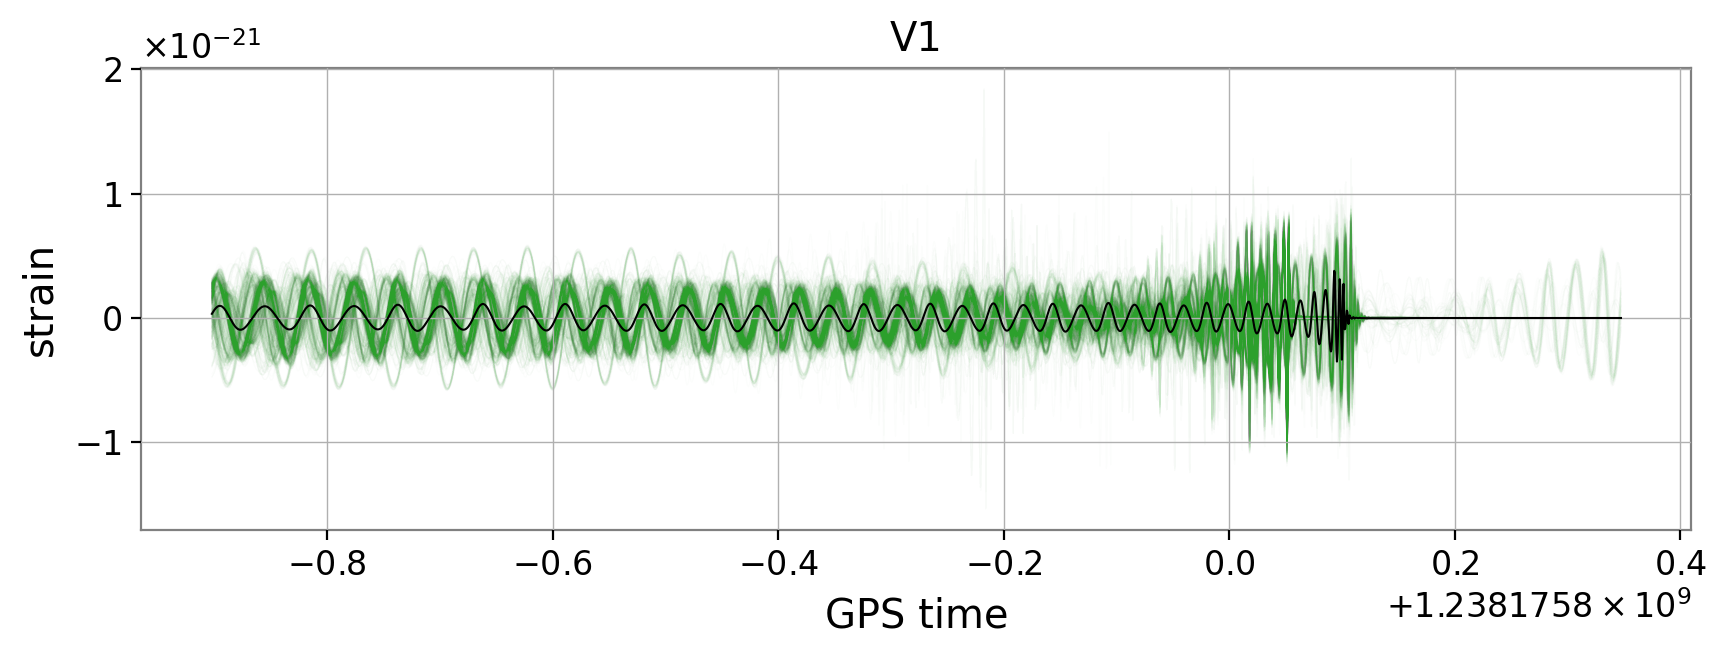

In [38]:
# Plot colored
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    plt.plot(lm.time_dict[ifo], injection_dict[ifo], color='k', zorder=5, lw=0.75)
    
    # full
    for j in range(len(wfs['samples'])):
        plt.plot(lm.time_dict[ifo], wfs['samples'][j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlabel('GPS time')
    plt.ylabel('strain')
    plt.show()

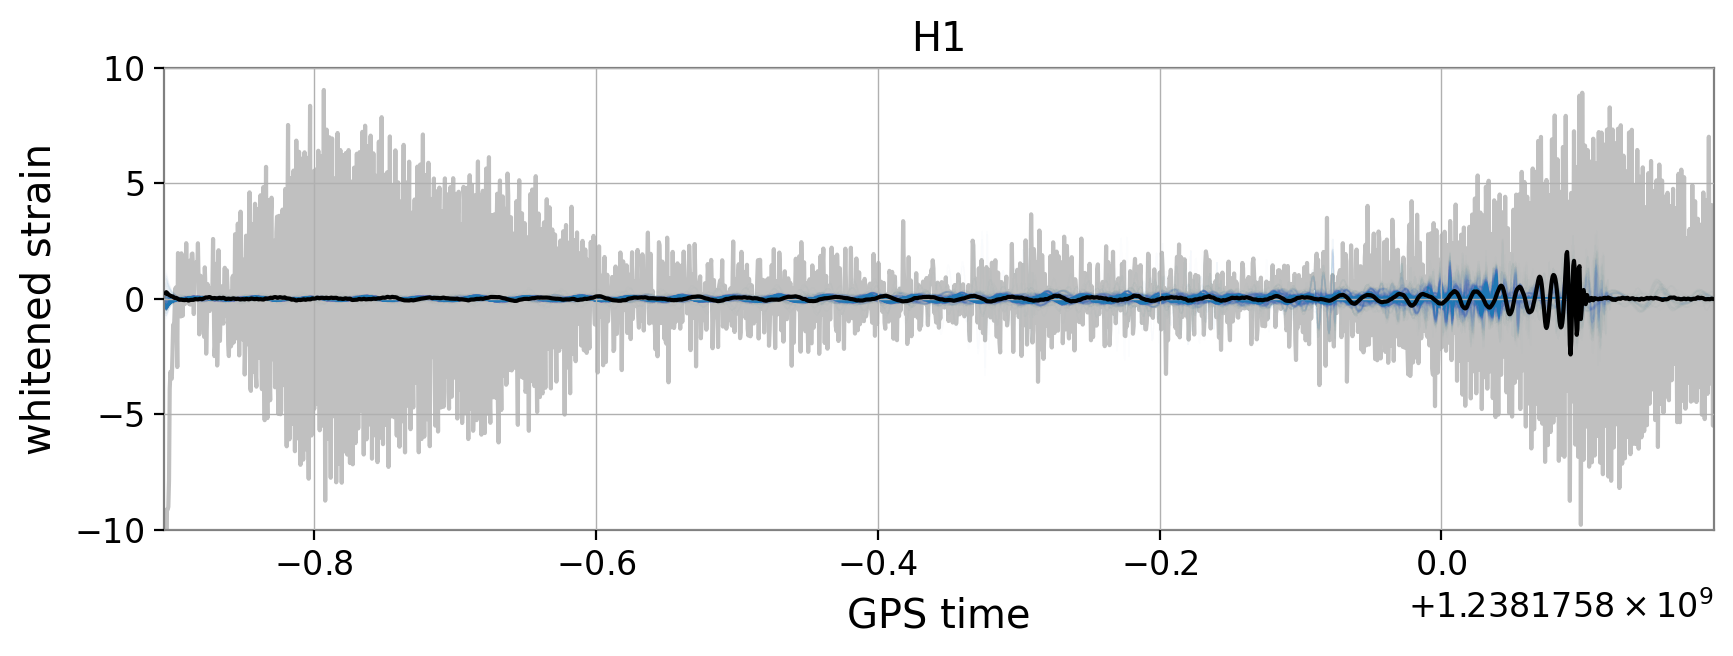

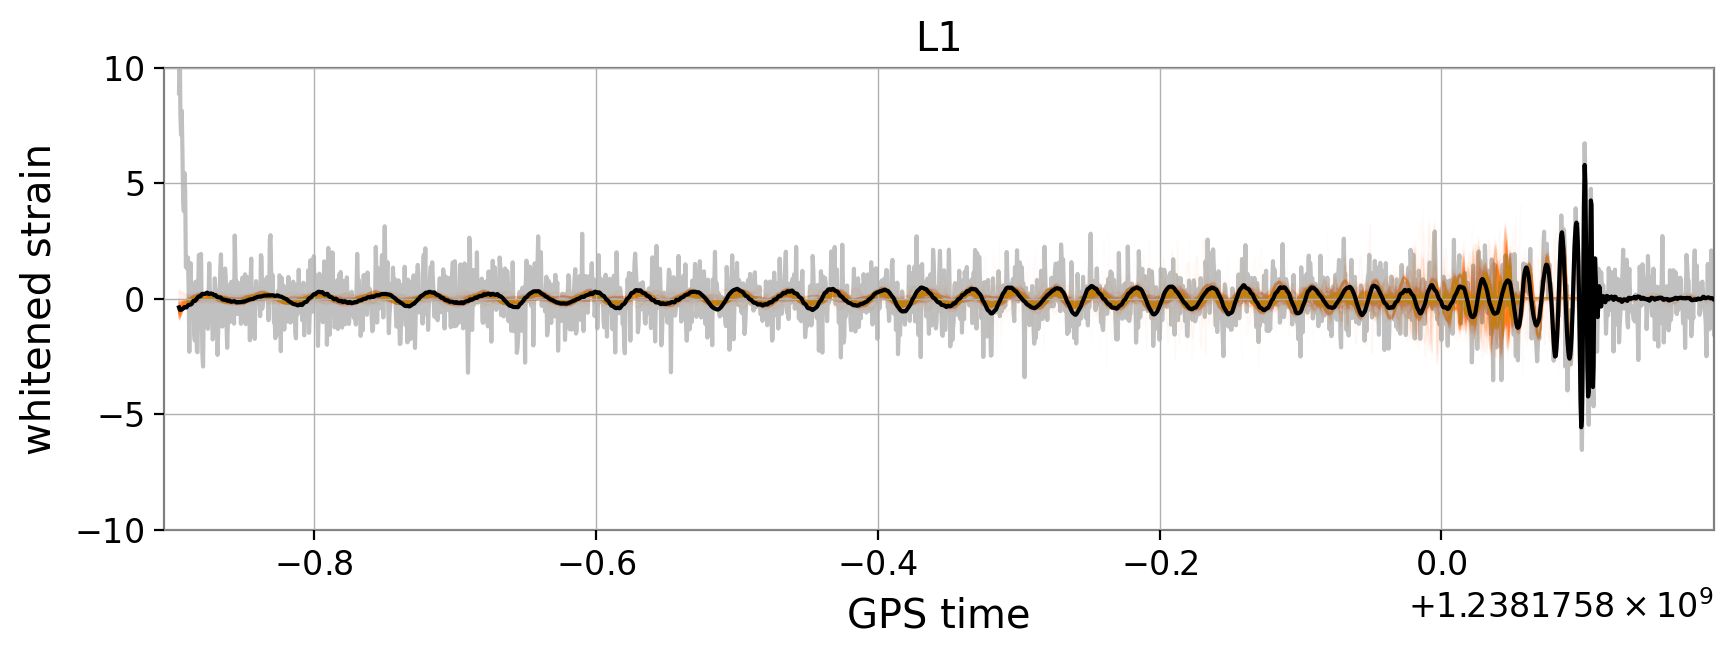

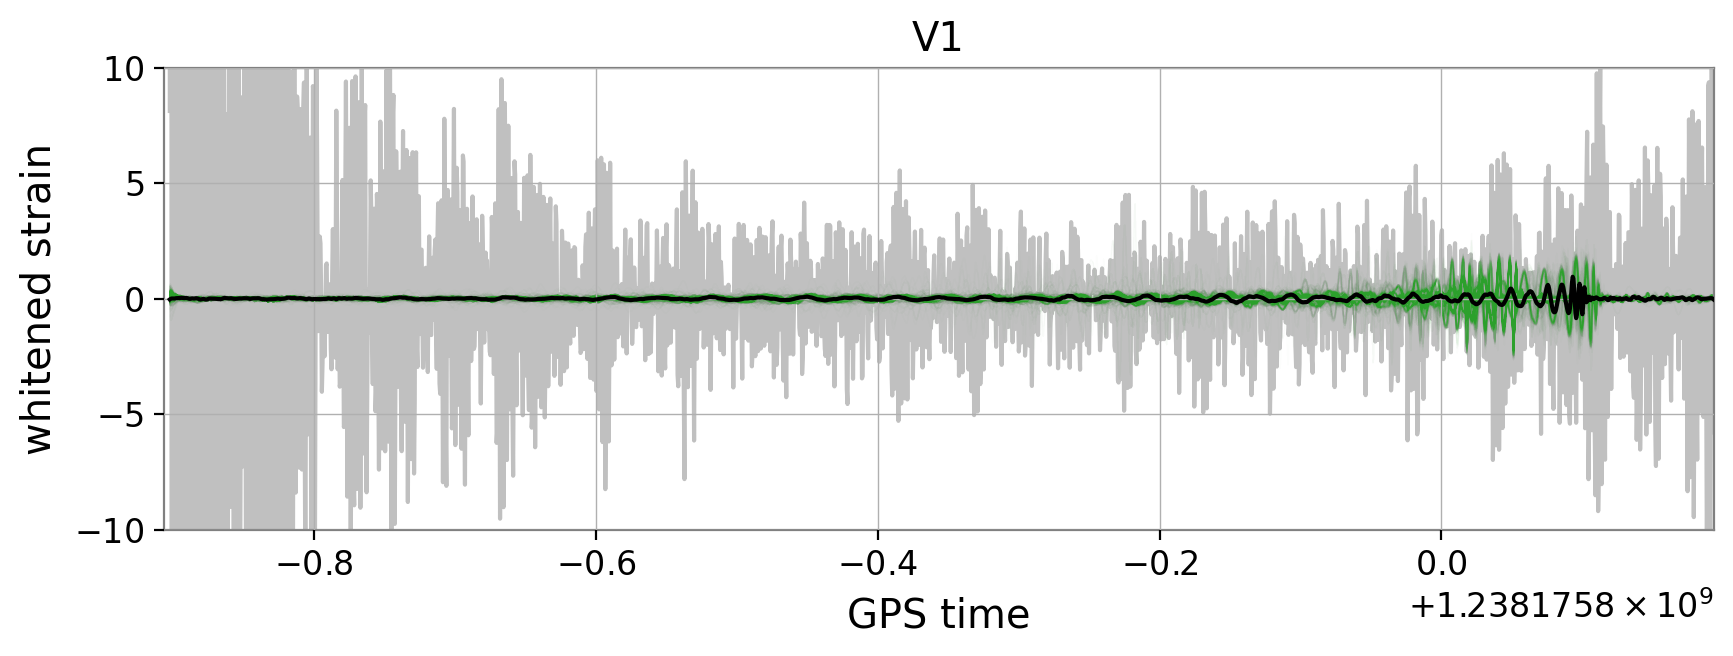

In [35]:
# Plot whitened
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    
    plt.plot(lm.time_dict[ifo], injection_dict_whitened[ifo], color='k', zorder=5)
    plt.plot(lm.time_dict[ifo], lm.whitened_data_dict[ifo], color='silver', zorder=0)

    # full
    for j in range(len(wfs_whitened)):
        plt.plot(lm.time_dict[ifo], wfs_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-1, lm.reference_time+0.1)
    plt.ylim(-10,10)
    plt.xlabel('GPS time')
    plt.ylabel('whitened strain')
    plt.show()

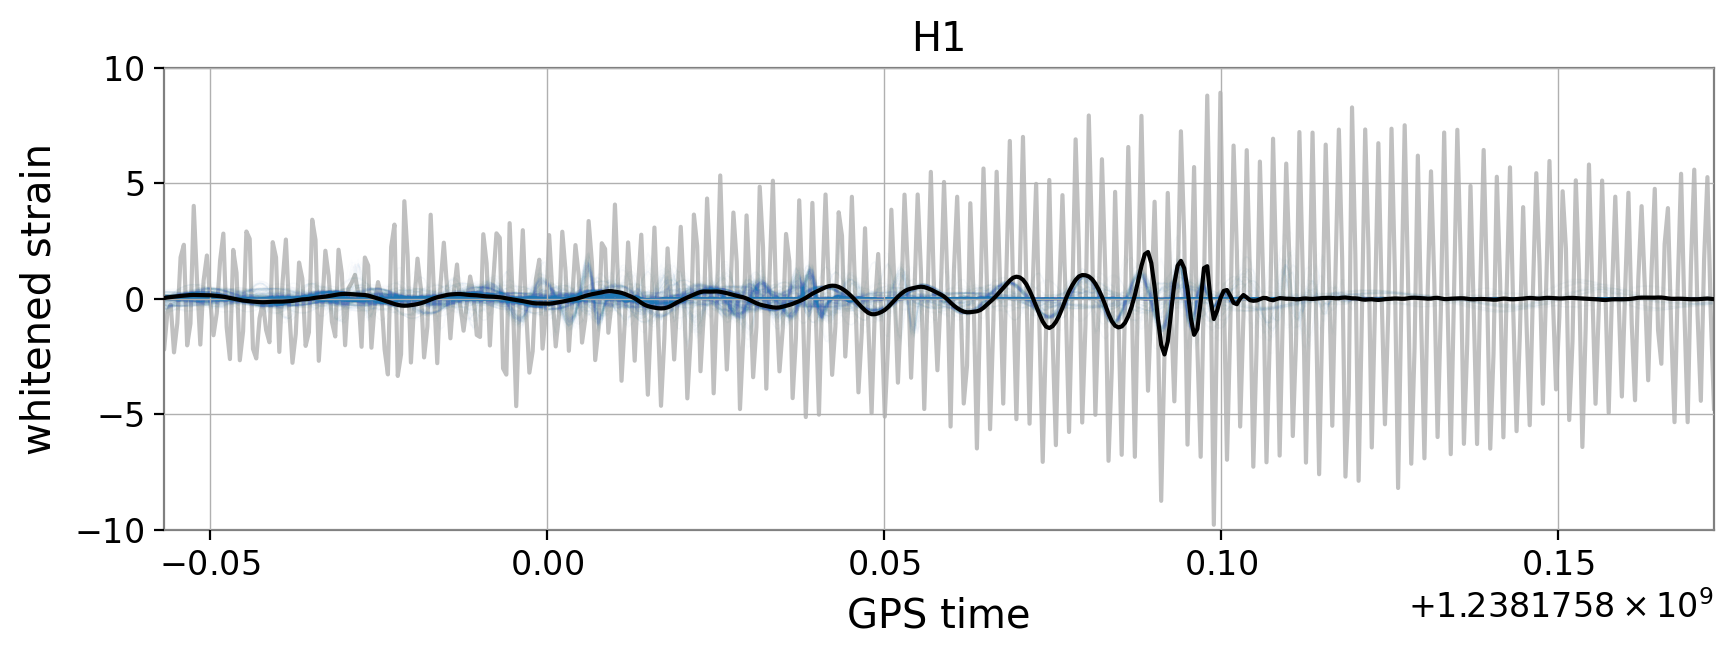

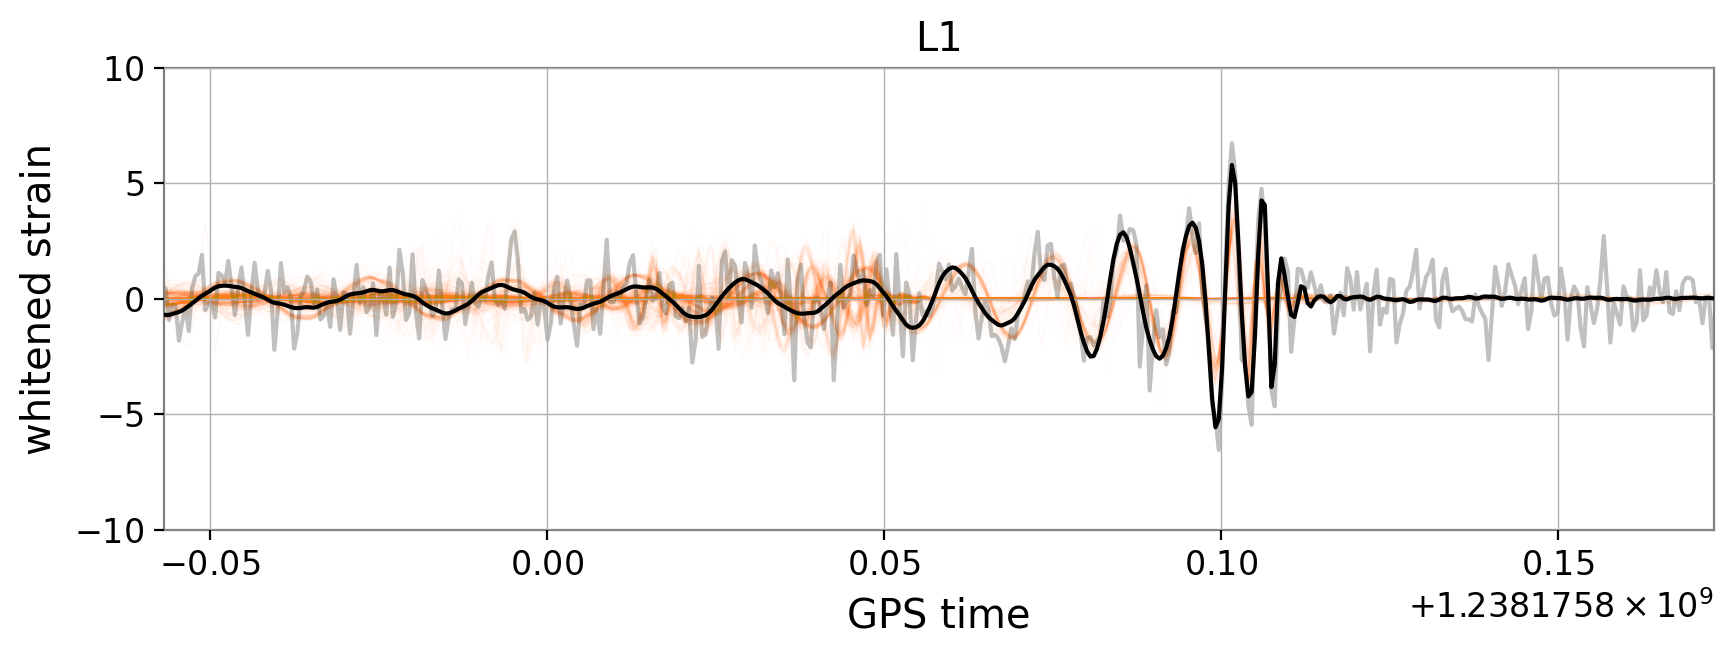

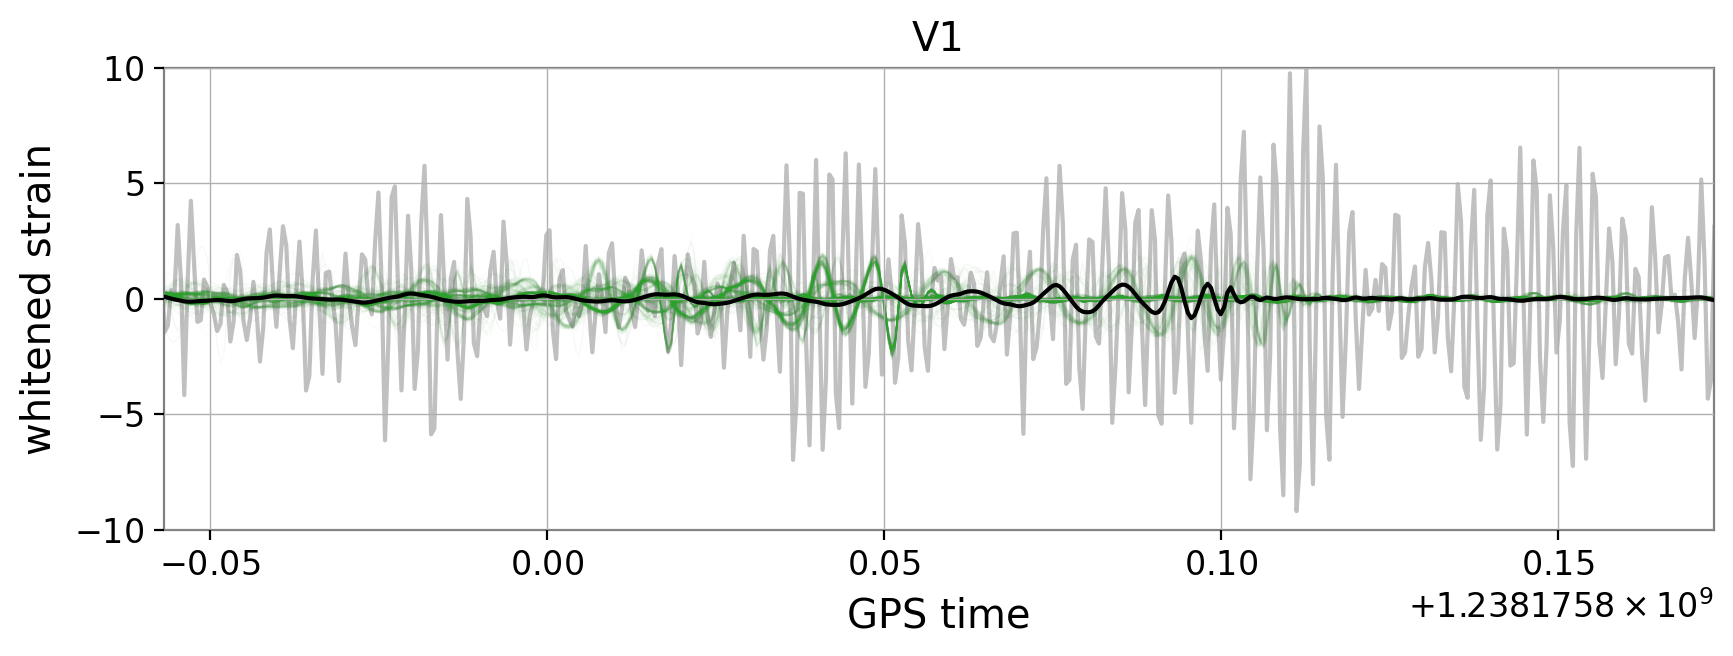

In [34]:
# Plot whitened (zoomed in around merger)
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    plt.plot(lm.time_dict[ifo], injection_dict_whitened[ifo], color='k', zorder=5)
    plt.plot(lm.time_dict[ifo], lm.whitened_data_dict[ifo], color='silver', zorder=0)

    # full
    for j in range(len(wfs_whitened)):
        plt.plot(lm.time_dict[ifo], wfs_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-0.15, lm.reference_time+0.08)
    plt.ylim(-10,10)
    plt.xlabel('GPS time')
    plt.ylabel('whitened strain')
    plt.show()

Are the residuals gaussian?

In [36]:
# Gaussian distribution
mean = 0 
std_dev = 1
x_values = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 500)
pdf_values = norm.pdf(x_values, loc=mean, scale=std_dev)

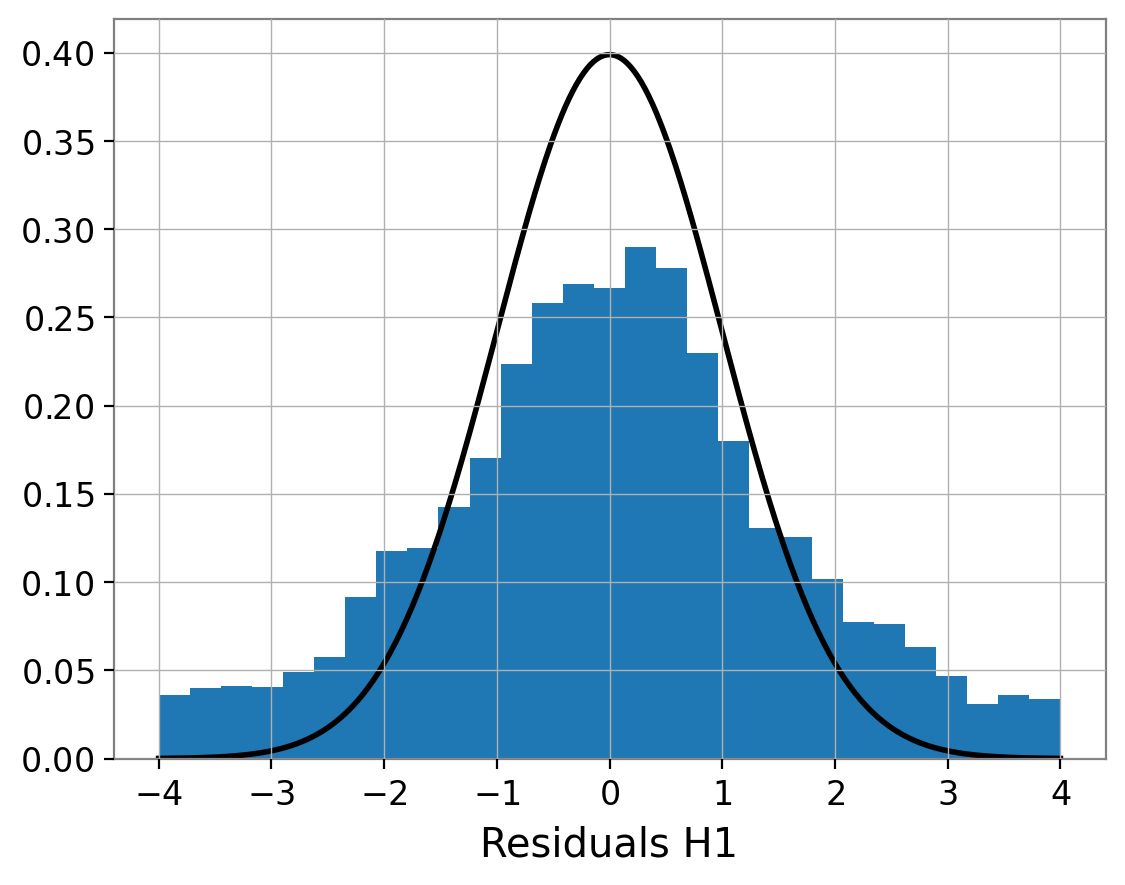

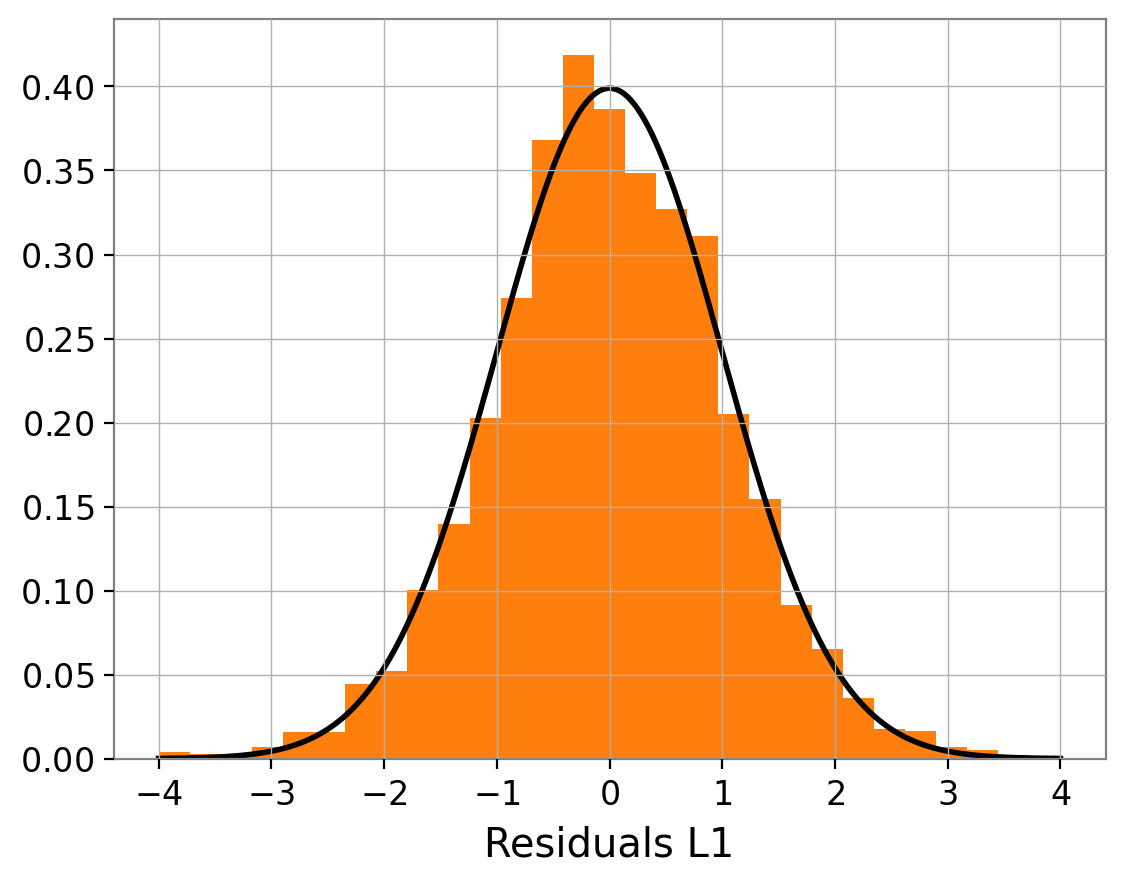

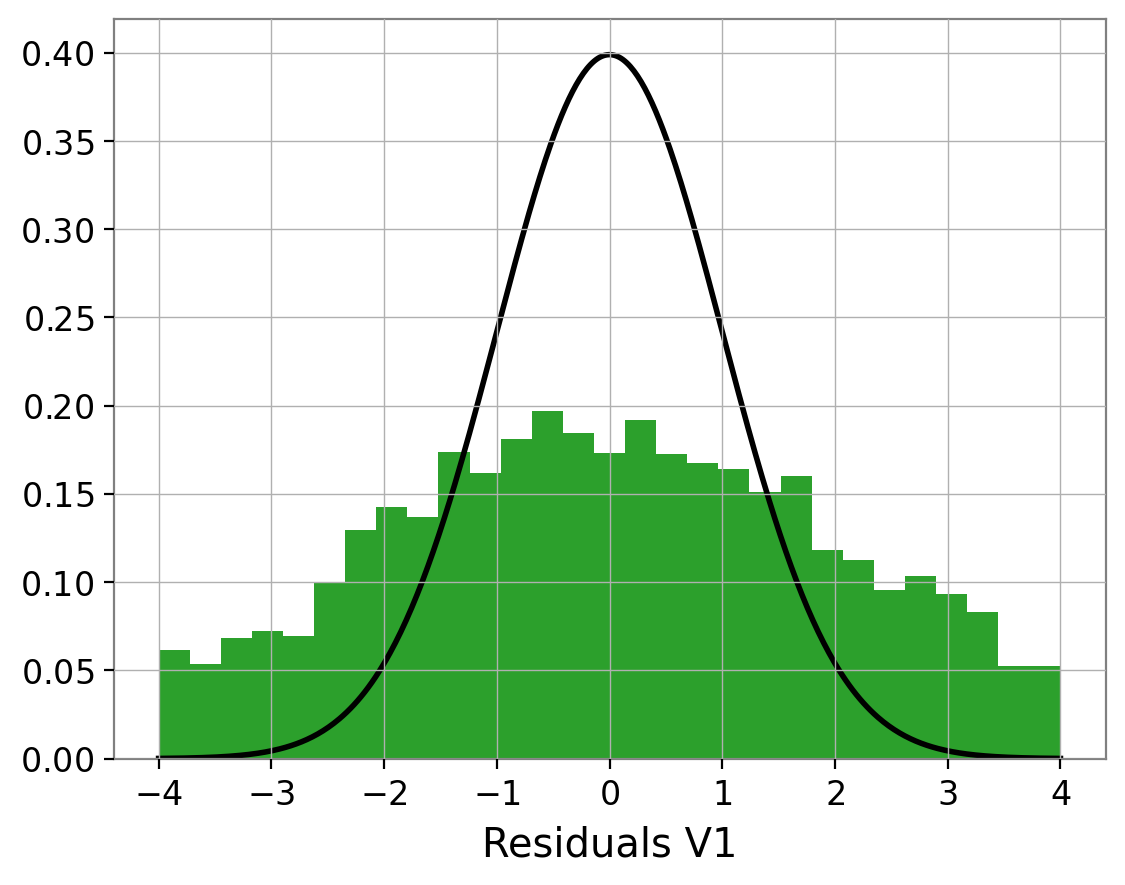

In [37]:
# Plot whitened
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo]
    mask = (times > lm.reference_time-1) & (times < lm.reference_time+0.1)
    strain = lm.whitened_data_dict[ifo][mask]

    plt.figure()

    residuals = []
    for j in range(len(wfs_whitened)):
        wf =  wfs_whitened[j][ifo][mask]
        residuals.append( strain - wf )

    flt_res = np.asarray(residuals).flatten()
    plt.hist(flt_res, color=f'C{i}', bins=np.linspace(-4,4,30), density=True)

    plt.plot(x_values, pdf_values, color='k', lw=2)
    plt.xlabel(f'Residuals {ifo}')
    plt.show()